# Setup

## Imports

In [19]:
from sklearn.ensemble import GradientBoostingRegressor as GBR
from helpers import displayAsDF, e, y_col
from sklearn.linear_model import Lasso, LinearRegression as LR, Ridge
from sklearn.model_selection import GridSearchCV as GSCV, train_test_split as TTS
from sklearn.feature_selection import SequentialFeatureSelector as SFS
from sklearn.metrics import make_scorer, mean_squared_error as MSE
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor as DTR
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Variables

In [20]:
RANDOM_STATE = 1432
salaries = pd.read_csv("salaries_processed.csv", index_col=0)

## Helpers

In [21]:
MSEScorer = make_scorer(MSE, greater_is_better=False)
RMSE = lambda *args, **kwargs: np.sqrt(MSE(*args, **kwargs))

def sfsSupport(model, X, y, nfts):
  sfs = SFS(model, direction="backward", scoring=MSEScorer, n_features_to_select=nfts)
  sfs.fit(X, y)
  return sfs.support_

makeMask = lambda mask: lambda X: X.loc[:, mask]
joinCols = lambda cols: ", ".join(cols)

def inspectSFS(model, X_train, X_test, y_train, y_test, tt = lambda y: y):
  cols = []
  rmses = []
  for n in range(X_train.shape[1]//2, X_train.shape[1]):
    # Backward feature elimination
    sfs_support = sfsSupport(model, X_train, y_train, n)
    X_mask = makeMask(sfs_support)
    model.fit(X_mask(X_train), y_train)
    cols.append(joinCols(X_train.columns[sfs_support]))
    rmses.append(RMSE(tt(y_test), tt(model.predict(X_mask(X_test)))))
  
  model.fit(X_train, y_train)
  cols.append(joinCols(X_train.columns))
  rmses.append(RMSE(tt(y_test), tt(model.predict(X_test))))
  
  displayAsDF(rmses, columns=["RMSE"], index=cols)

# Modelling

## Preparation

In [22]:
X = salaries.drop(columns=y_col)
y = salaries[y_col]

tts = TTS(X, y, test_size=1/3, random_state=RANDOM_STATE)
Xs = tts[:2]
ys = tts[2:]

### Log y (`salary_in_usd`)

The distribution of y is skewed, whether logged or not, so both original and logged ys can be compared based on results then.

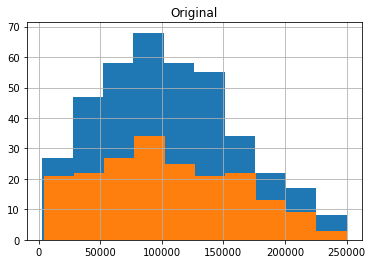

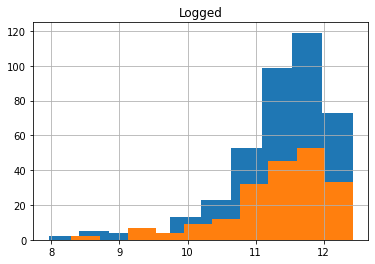

In [23]:
[y.hist() for y in ys]
plt.title("Original")
plt.show()

y_logs = [y.agg(np.log) for y in ys]
[y.hist() for y in y_logs]
plt.title("Logged")
plt.show()

In [24]:
def compareSFS(model):
  print("y")
  inspectSFS(model, *Xs, *ys)
  print("y logged")
  inspectSFS(model, *Xs, *y_logs, e)

## Exploration

### Linear Regression (LR)

In [25]:
lr = LR()
compareSFS(lr)

y


,RMSE
"experience_level, ricl, company_location",42423.728905
"experience_level, ricl, company_location, company_size",42093.422407
"experience_level, job_popularity, ricl, company_location, company_size",42416.774707
"work_year, experience_level, job_popularity, ricl, company_location, company_size",42224.046134
"work_year, experience_level, job_popularity, ricl, remote_ratio, company_location, company_size",42096.064031


y logged


,RMSE
"experience_level, ricl, company_location",41665.682245
"experience_level, ricl, company_location, company_size",40906.428919
"work_year, experience_level, ricl, company_location, company_size",40873.297718
"work_year, experience_level, job_popularity, ricl, company_location, company_size",40926.885415
"work_year, experience_level, job_popularity, ricl, remote_ratio, company_location, company_size",40608.496594


### Ridge

In [26]:
ridge = Ridge()
compareSFS(ridge)

y


,RMSE
"experience_level, ricl, company_location",42500.607097
"experience_level, ricl, company_location, company_size",42172.021777
"experience_level, job_popularity, ricl, company_location, company_size",42488.701213
"work_year, experience_level, job_popularity, ricl, company_location, company_size",42263.156701
"work_year, experience_level, job_popularity, ricl, remote_ratio, company_location, company_size",42129.790502


y logged


,RMSE
"experience_level, ricl, company_location",41819.587857
"experience_level, ricl, company_location, company_size",41070.367347
"work_year, experience_level, ricl, company_location, company_size",41058.161349
"work_year, experience_level, job_popularity, ricl, company_location, company_size",41105.989793
"work_year, experience_level, job_popularity, ricl, remote_ratio, company_location, company_size",40788.878948


### Lasso

In [27]:
lasso = Lasso()
compareSFS(lasso)

y


,RMSE
"experience_level, ricl, company_location",42424.336562
"experience_level, ricl, company_location, company_size",42093.978393
"experience_level, job_popularity, ricl, company_location, company_size",42417.049506
"work_year, experience_level, job_popularity, ricl, company_location, company_size",42224.315501
"work_year, experience_level, job_popularity, ricl, remote_ratio, company_location, company_size",42096.505482


y logged


,RMSE
"remote_ratio, company_location, company_size",60907.716107
"ricl, remote_ratio, company_location, company_size",60907.716107
"job_popularity, ricl, remote_ratio, company_location, company_size",60907.716107
"experience_level, job_popularity, ricl, remote_ratio, company_location, company_size",60907.716107
"work_year, experience_level, job_popularity, ricl, remote_ratio, company_location, company_size",60907.716107


### Regression Tree (RT)

In [28]:
rt = DTR()
compareSFS(rt)

y


,RMSE
"experience_level, ricl, company_location",43369.062365
"experience_level, ricl, remote_ratio, company_location",45303.186478
"experience_level, ricl, remote_ratio, company_location, company_size",47339.760736
"work_year, experience_level, ricl, remote_ratio, company_location, company_size",47798.084763
"work_year, experience_level, job_popularity, ricl, remote_ratio, company_location, company_size",50133.414504


y logged


,RMSE
"work_year, job_popularity, company_location",49974.824208
"experience_level, job_popularity, ricl, company_location",49758.836971
"experience_level, job_popularity, ricl, remote_ratio, company_location",47446.795951
"work_year, experience_level, job_popularity, ricl, remote_ratio, company_location",48942.232223
"work_year, experience_level, job_popularity, ricl, remote_ratio, company_location, company_size",45086.880987


### Gradient Boosting Regression (GBR)

In [29]:
gbr = GBR(random_state=RANDOM_STATE)
compareSFS(gbr)

y


,RMSE
"experience_level, job_popularity, company_location",45159.302209
"experience_level, job_popularity, ricl, company_location",42179.380084
"work_year, experience_level, job_popularity, ricl, company_location",41510.961113
"work_year, experience_level, job_popularity, ricl, company_location, company_size",40137.057236
"work_year, experience_level, job_popularity, ricl, remote_ratio, company_location, company_size",40117.742579


y logged


,RMSE
"experience_level, job_popularity, company_location",45003.020954
"experience_level, job_popularity, ricl, company_location",42007.846080
"work_year, experience_level, job_popularity, ricl, company_location",42324.137049
"work_year, experience_level, job_popularity, ricl, company_location, company_size",41148.833881
"work_year, experience_level, job_popularity, ricl, remote_ratio, company_location, company_size",40662.190734


### Support Vector Regression (SVR)

In [30]:
svr = SVR()
compareSFS(svr)

y


,RMSE
"experience_level, ricl, company_location",58362.998955
"experience_level, ricl, company_location, company_size",58372.116942
"experience_level, ricl, remote_ratio, company_location, company_size",58379.044224
"experience_level, job_popularity, ricl, remote_ratio, company_location, company_size",58384.652798
"work_year, experience_level, job_popularity, ricl, remote_ratio, company_location, company_size",58402.624842


y logged


,RMSE
"experience_level, job_popularity, company_location",44906.015061
"experience_level, job_popularity, company_location, company_size",41951.907254
"experience_level, job_popularity, ricl, company_location, company_size",40467.630102
"experience_level, job_popularity, ricl, remote_ratio, company_location, company_size",40292.601548
"work_year, experience_level, job_popularity, ricl, remote_ratio, company_location, company_size",58367.291076


## Shortlisting

The models that perform best are:

| No. | Model     | Features       | y logged | RMSE  |
| --- | --------- | -------------- | -------- | ----- |
| 1   | **GBR**   | All            | No       | 40118 |
| 2   | **SVR**   | No `work_year` | Yes      | 40293 |
| 3   | **LR**    | All            | Yes      | 40608 |

## Hyperparameter Tuning

In [31]:
def tuneHyper(pg, Xs, ys, Model, tt=lambda y: y, **model_kwargs):
  gscv = GSCV(Model(**model_kwargs), pg, scoring=MSEScorer)
  gscv.fit(Xs[0], ys[0])
  print(f"Best Params: {gscv.best_params_}")

  model_tuned = Model(**gscv.best_params_, **model_kwargs)
  model_tuned.fit(Xs[0], ys[0])
  print(f"RMSE: {RMSE(tt(ys[1]), tt(model_tuned.predict(Xs[1])))}")
  return model_tuned

### GBR

In [38]:
gbr_pg = {
  "learning_rate": [.1, .01],
  "n_estimators": np.arange(30, 70, 10),
  "max_leaf_nodes": np.arange(4, 8, 1),
  "tol": np.arange(.1, .3, .05)
}
gbr_tuned = tuneHyper(gbr_pg, Xs, ys, GBR, random_state=RANDOM_STATE)

Best Params: {'learning_rate': 0.1, 'max_leaf_nodes': 4, 'n_estimators': 60, 'tol': 0.1}
RMSE: 40415.863686479504


### SVR

In [39]:
svr_pg = {
  "tol": np.arange(.12, .15, .005),
  "C": np.arange(.6, .9, .05),
  "epsilon": np.arange(.1, .5, .1)
}
svrX = lambda X: X.drop(columns="work_year")
svr_Xs = [svrX(X) for X in Xs]
svr_tuned = tuneHyper(svr_pg, svr_Xs, y_logs, SVR, e)

Best Params: {'C': 0.7500000000000001, 'epsilon': 0.2, 'tol': 0.14500000000000002}
RMSE: 39685.80307943052


### LR

LR has no parameters that can be optimized

## The best performing model is:

**SVR** w/
- Features: No `work_year`
- y logged
- Params:
{
 'C': 0.75,
 'epsilon': 0.2,
 'tol': 0.145
}
- *RMSE: 39686*

# Exports

In [34]:
from joblib import dump

In [35]:
# Retrain w/ all available data
svr_tuned.fit(svrX(X), y.agg(np.log))
dump(svr_tuned, "../model.pkl")

['../model.pkl']